# Differential Expression with limma-voom pipeline - Genes

In [1]:
suppressMessages({library(SummarizedExperiment)
                  library(data.table)
                  library(tidyverse)
                  library(limma)
                  library(edgeR)
                  library(sva)})

## Prepare Data

In [6]:
# Function from jaffelab github
merge_rse_metrics <- function(rse) {
    stopifnot(is(rse, 'RangedSummarizedExperiment'))
    stopifnot(
        c('concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
          'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
          'mitoMapped', 'totalMapped') %in%
            colnames(SummarizedExperiment::colData(rse))
    )

    stopifnot(all(sapply(c(
        'concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
        'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
        'mitoMapped', 'totalMapped'), function(var) {
            is(colData(rse)[, var], 'List')
        })
    ))

    rse$concordMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$concordMapRate, rse$numReads)
    rse$overallMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$overallMapRate, rse$numReads)
    rse$mitoRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$mitoRate, rse$numMapped)
    rse$rRNA_rate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$rRNA_rate, rse$numMapped)
    rse$totalAssignedGene = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$totalAssignedGene, rse$numMapped)

    rse$numMapped = sapply(rse$numMapped, sum)
    rse$numReads = sapply(rse$numReads, sum)
    rse$numUnmapped = sapply(rse$numUnmapped, sum)
    rse$mitoMapped = sapply(rse$mitoMapped, sum)
    rse$totalMapped = sapply(rse$totalMapped, sum)
    return(rse)
}

### Load gene counts

In [2]:
load(paste0("/ceph/projects/v3_phase3_paper/inputs/phase3/_m/count_data/", 
            "caudate_brainseq_phase3_hg38_rseJxn_merged_n464.rda"))
rse_jxn

class: RangedSummarizedExperiment 
dim: 1311958 464 
metadata(0):
assays(1): counts
rownames(1311958): chr1:11672-12009(+) chr1:13115-183634(+) ...
  chrY:57210793-57211551(-) chrY:57213965-57214349(-)
rowData names(15): inGencode inGencodeStart ... newGeneSymbol isFusion
colnames(464): R12864 R12865 ... R13503 R13504
colData names(71): BrNum RNum ... RNum.1 FlowCell

### Load genotype data

In [3]:
mds_file = paste0("/ceph/projects/v3_phase3_paper/inputs/genotypes/to_brnum/", 
                  "merge/to_plink/mds/_m/merged.mds")
mds = fread(mds_file) %>% 
    rename("snpPC1"="C1", "snpPC2"="C2", "snpPC3"="C3", 
           "snpPC4"="C4", "snpPC5"="C5") %>%
    mutate_if(is.character, as.factor)

class: RangedSummarizedExperiment 
dim: 1311958 464 
metadata(0):
assays(1): counts
rownames(1311958): chr1:11672-12009(+) chr1:13115-183634(+) ...
  chrY:57210793-57211551(-) chrY:57213965-57214349(-)
rowData names(15): inGencode inGencodeStart ... newGeneSymbol isFusion
colnames(464): R12864 R12865 ... R13503 R13504
colData names(81): BrNum RNum ... snpPC9 snpPC10

### Subset and recode

In [4]:
keepIndex = which((rse_jxn$Dx %in% c("Control", "Schizo")) & 
                  rse_jxn$Age > 17 & 
                  rse_jxn$Race %in% c("AA", "CAUC"))
rse_jxn = rse_jxn[, keepIndex]
rse_jxn$Dx = factor(rse_jxn$Dx, levels = c("Control", "Schizo"))
rse_jxn$Sex <- factor(rse_jxn$Sex)
rse_jxn

class: RangedSummarizedExperiment 
dim: 1311958 394 
metadata(0):
assays(1): counts
rownames(1311958): chr1:11672-12009(+) chr1:13115-183634(+) ...
  chrY:57210793-57211551(-) chrY:57213965-57214349(-)
rowData names(15): inGencode inGencodeStart ... newGeneSymbol isFusion
colnames(394): R12864 R12865 ... R13503 R13504
colData names(81): BrNum RNum ... snpPC9 snpPC10

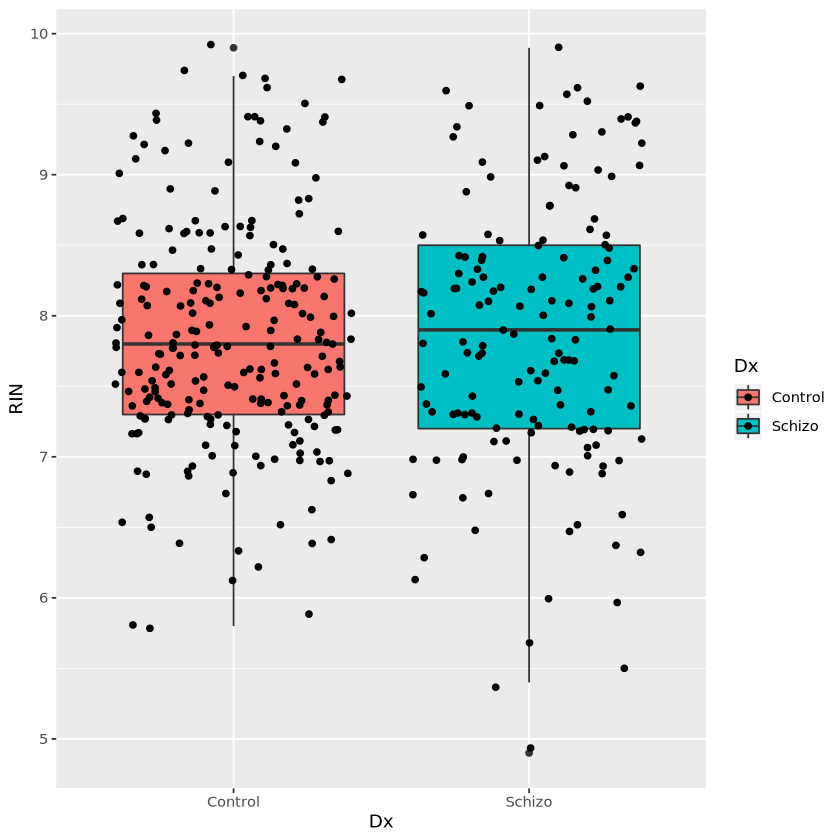

In [7]:
rse_jxn <- merge_rse_metrics(rse_jxn)

rse_jxn$ERCCsumLogErr <- mapply(function(r, n) {
        sum(r * n)/sum(n)
    }, rse_jxn$ERCCsumLogErr, rse_jxn$numReads)
colData(rse_jxn)$RIN = sapply(colData(rse_jxn)$RIN,"[",1)

pheno = colData(rse_jxn) %>% as.data.frame %>% 
    inner_join(mds, by=c("BrNum"="FID"))

### Generate DGEList

In [9]:
x <- DGEList(counts=assays(rse_jxn)$counts, 
             genes=rowData(rse_jxn), samples=pheno)

### Filtering low counts

In [10]:
design0 <- model.matrix(~Dx*Sex, data=x$samples)
keep.x <- filterByExpr(x, design=design0)
x <- x[keep.x, , keep.lib.sizes=FALSE]
print(paste('There are:', sum(keep.x), 'features left!', sep=' '))

[1] "There are: 176228 features left!"


### Normalize counts

In [11]:
x <- calcNormFactors(x, method="TMM")

## Differential Expression Analysis

### Design matrix

In [12]:
mod = model.matrix(~Dx*Sex + Age + mitoRate +
        rRNA_rate + totalAssignedGene + RIN +
        ERCCsumLogErr + overallMapRate +
        snpPC1 + snpPC2 + snpPC3,
        data = x$samples)

colnames(mod) <- gsub("Dx", "", colnames(mod))
colnames(mod) <- gsub("SexM", "Male", colnames(mod))
colnames(mod) <- gsub("Schizo:Male", "Schizo_Male", colnames(mod))
colnames(mod) <- gsub("\\(Intercept\\)", "Intercept",
                         colnames(mod))

head(mod, 2)

,Intercept,Schizo,Male,Age,mitoRate,rRNA_rate,totalAssignedGene,RIN,ERCCsumLogErr,overallMapRate,snpPC1,snpPC2,snpPC3,snpPC4,snpPC5,Schizo_Male
R12864,1,1,0,42.98,0.03265387,8.675159e-05,0.5148545,9.6,-59.97567,0.9093498,0.0493213,-0.00560004,-1.25945e-03,0.00109117,0.000905945,0
R12865,1,1,1,53.12,0.01978740,6.976684e-05,0.5207789,9.5,-45.71034,0.8734840,0.0630991,-0.00499613,2.93356e-05,0.00104552,-0.001195790,1


### Calculate SVAs

In [14]:
null.model = mod %>% as.data.frame %>% 
    select(-c("Male", "Schizo", "Schizo_Male")) %>% as.matrix
head(null.model, 2)

,Intercept,Schizo,Age,mitoRate,rRNA_rate,totalAssignedGene,RIN,ERCCsumLogErr,overallMapRate,snpPC1,snpPC2,snpPC3,snpPC4,snpPC5
R12864,1,1,42.98,0.03265387,8.675159e-05,0.5148545,9.6,-59.97567,0.9093498,0.0493213,-0.00560004,-1.25945e-03,0.00109117,0.000905945
R12865,1,1,53.12,0.01978740,6.976684e-05,0.5207789,9.5,-45.71034,0.8734840,0.0630991,-0.00499613,2.93356e-05,0.00104552,-0.001195790


In [15]:
print(paste('Determining number of surragate variables ...', Sys.time(), sep=' '))
n.sv <- num.sv(x$counts, mod, method="be")

print(paste('Fitting SV model ...', Sys.time(), sep=' '))
svobj <- svaseq(x$counts, mod, null.model, n.sv=n.sv)

[1] "Determining number of surragate variables ... 2020-01-25 12:12:40"
[1] "Fitting SV model ... 2020-01-25 12:16:27"
Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5  

### Merge models

In [16]:
print(paste('Adding SV to design matrix ...', Sys.time(), sep=' '))
modQsva <- cbind(mod, svobj$sv)
len.d <- length(colnames(modQsva))
colnames(modQsva)[((len.d - n.sv)+1):len.d] <- make.names(paste0("sv",1:n.sv))

[1] "Adding SV to design matrix ... 2020-01-25 12:16:51"


### Preform voom

In [ ]:
v <- voom(x, modQsva, plot=TRUE)

In [25]:
feature = 'junctions'
dir.create(feature)

save(v, file=paste0(feature,'/voomSVA.RData'))

### Calculate residuals

In [26]:
null_model = v$design %>% as.data.frame %>% 
    select(-c("Male", "Schizo", "Schizo_Male")) %>% as.matrix
fit_res <- lmFit(v, design=null_model)
res = v$E - ( fit_res$coefficients %*% t(null_model) )
res_sd = apply(res, 1, sd)
res_mean = apply(res, 1, mean)

### Normalize residuals and write to file

In [27]:
res_norm = (res - res_mean) / res_sd
write.table(res_norm, file=paste0(feature, '/residualized_expression.tsv'),
            sep="\t", quote=FALSE)

### Fit model with limma

In [ ]:
fit0 <- lmFit(v, modQsva)
contr.matrix <- makeContrasts(CtrlvsSZ = Schizo,
                              MvsF = Male,
                              Interaction = Schizo_Male,
                              levels=colnames(modQsva))
fit <- contrasts.fit(fit0, contrasts=contr.matrix)

### Calculate differential expression with eBayes

In [ ]:
save_volcanoPlot <- function(top, label){
    pdf(file=paste0(feature, "/volcanoPlot_", label, ".pdf"), 8, 6)
    with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
    with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                              pch=20, col='red', cex=0.6))
    with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                              pch=20, col='orange', cex=0.6))
    with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
         points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))
    dev.off()
}


save_MAplot <- function(top, label){
    pdf(file=paste0(feature, "/MAplot_", label, ".pdf"), 8, 6)
    with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
    with(subset(top, adj.P.Val<0.05),
         points(AveExpr, logFC, col="red", pch=20, cex=0.5))
    dev.off()
}


extract_de <- function(contrast, label, fit){
    top <- topTable(fit, coef=contrast, number=Inf, sort.by="P")
    top <- top[order(top$P.Value), ]
    top.fdr <- top %>% filter(adj.P.Val<=0.05)
    print(paste("Comparison for:", label))
    print(paste('There are:', dim(top.fdr)[1], 'DE features!'))
    fwrite(top, 
           file=paste0(feature, "/diffExpr_", label, "_full.txt"), 
           sep='\t', row.names=TRUE)
    fwrite(top.fdr, 
           file=paste0(feature, "/diffExpr_", label, "_FDR05.txt"), 
           sep='\t', row.names=TRUE)
    save_volcanoPlot(top, label)
    save_MAplot(top, label)
}

In [19]:
options(width=200)
esv <- eBayes(fit)

#### SZ vs Ctrl

In [19]:
extract_de(1, 'szVctl', esv)

[1] 25373    18

#### Male vs Female

In [22]:
extract_de(2, 'maleVfemale', esv)

[1] 25373    18

#### Interaction

In [25]:
extract_de(3, 'interaction', esv)

[1] 25373    18

## Repreducibility Information

In [40]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2019-06-06 15:55:45 EDT"

    user   system  elapsed 
3433.034   61.322  702.555 

- Session info -------------------------------------------------------------------------------------------------------
 setting  value                       
 version  R version 3.5.0 (2018-04-23)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  C                           
 ctype    C                           
 tz       America/New_York            
 date     2019-06-06                  

- Packages -----------------------------------------------------------------------------------------------------------
 package              * version   date       lib source        
 annotate               1.60.0    2018-10-30 [1] Bioconductor  
 AnnotationDbi          1.44.0    2018-10-30 [1] Bioconductor  
 assertthat             0.2.0     2017-04-11 [1] CRAN (R 3.5.0)
 base64enc              0.1-3     2015-07-28 [1] CRAN (R 3.5.0)
 bindr                  0.1.1     2018-03-13 [1] CR